<div style="font-size: 40pt; font-weight: bold; padding: 40px 0 20px 0">Simultaenous Training</div>

**by Eric Klavins**

Copyright &copy; 2019, University of Washington

**Abstract**: The Hydrophobic-polar (HP) protein folding model is a simplified 2D model of protein folding that was used to show that tasks such as findinfg the minimum eneryg conformation of a protein are NP-Hard. Here, we  simultaneously learn the energy function of the HP model and find the minimum free energy of an HP protein. 

# Includes

In [1]:
from __future__ import print_function

import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import namedtuple
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from hp import HP
from translate import Translate, Encoder, Decoder
from energy import Energy

%matplotlib inline

dev = "cuda:0"

# Optimize

In [6]:
NUM_SAMPLES = 100
LENGTH = 20
TLR = 0.00001
ELR = 0.0001
EPISODES = 4000
TEMP = 2

translate = Translate(Encoder(LENGTH), Decoder(LENGTH,temperature=TEMP))
translate.to(dev)

energy = Energy(LENGTH)
energy.to(dev)

energy_optimizer = optim.Adam(energy.parameters(), lr=ELR)
translate_optimizer = optim.Adam(translate.parameters(), lr=TLR)
mse_loss = nn.MSELoss(reduction="sum")

# Make a list of sequences
sequences = torch.stack([HP.random(LENGTH,h_prob=i/NUM_SAMPLES).one_hot().to(dev) for i in range(NUM_SAMPLES)])

losses = []
totals = []

for episode in range(EPISODES):

    # Run Translate Network on the sequences to get conforamations
    conformations = translate(sequences)

    # Run Energy Network on conformations to get energy approximations
    energy_estimates = energy(energy.combine(sequences,conformations))
    
    for e in energy_estimates:
        translate_optimizer.zero_grad()
        e.backward(retain_graph=True)
        translate_optimizer.step()
        
    # Find actual energies of conformations
    energies = torch.tensor([
        HP.energy_of_one_hot(s,c) 
        for s,c in zip(sequences,conformations)
    ],dtype=torch.float,device=dev)
    
    energies = energies.unsqueeze(1)   

    # Compute MSE on energy approximations minus actual energies
    energy_loss = mse_loss(energies, energy_estimates)

    # Take a gradient step on the Energy Network
    energy_optimizer.zero_grad()
    energy_loss.backward()
    energy_optimizer.step()
    
    # Log data
    sys.stdout.write("\r%d. Total energy estimate: %f\tLoss: %f" % (episode+1,energy_estimates.sum(),energy_loss))
    losses.append(energy_loss)
    totals.append(energy_estimates.sum())


4000. Total energy: 9798.125000	Loss: 34266.550781600

Text(0, 0.5, 'Total Estimated Energy')

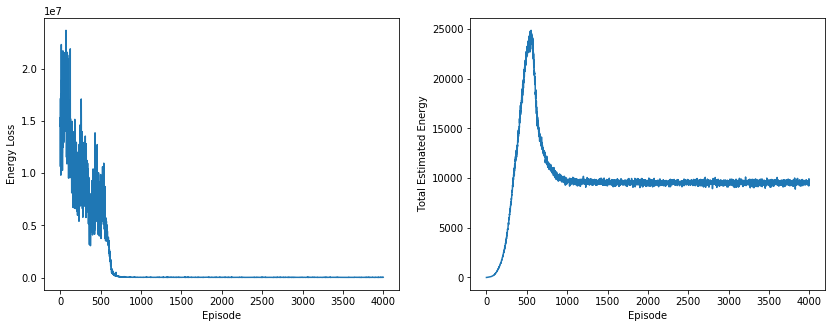

In [10]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(losses)
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Energy Loss")
#ax[0].set_ylim(0,90000)
ax[1].plot(totals)
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Total Estimated Energy")

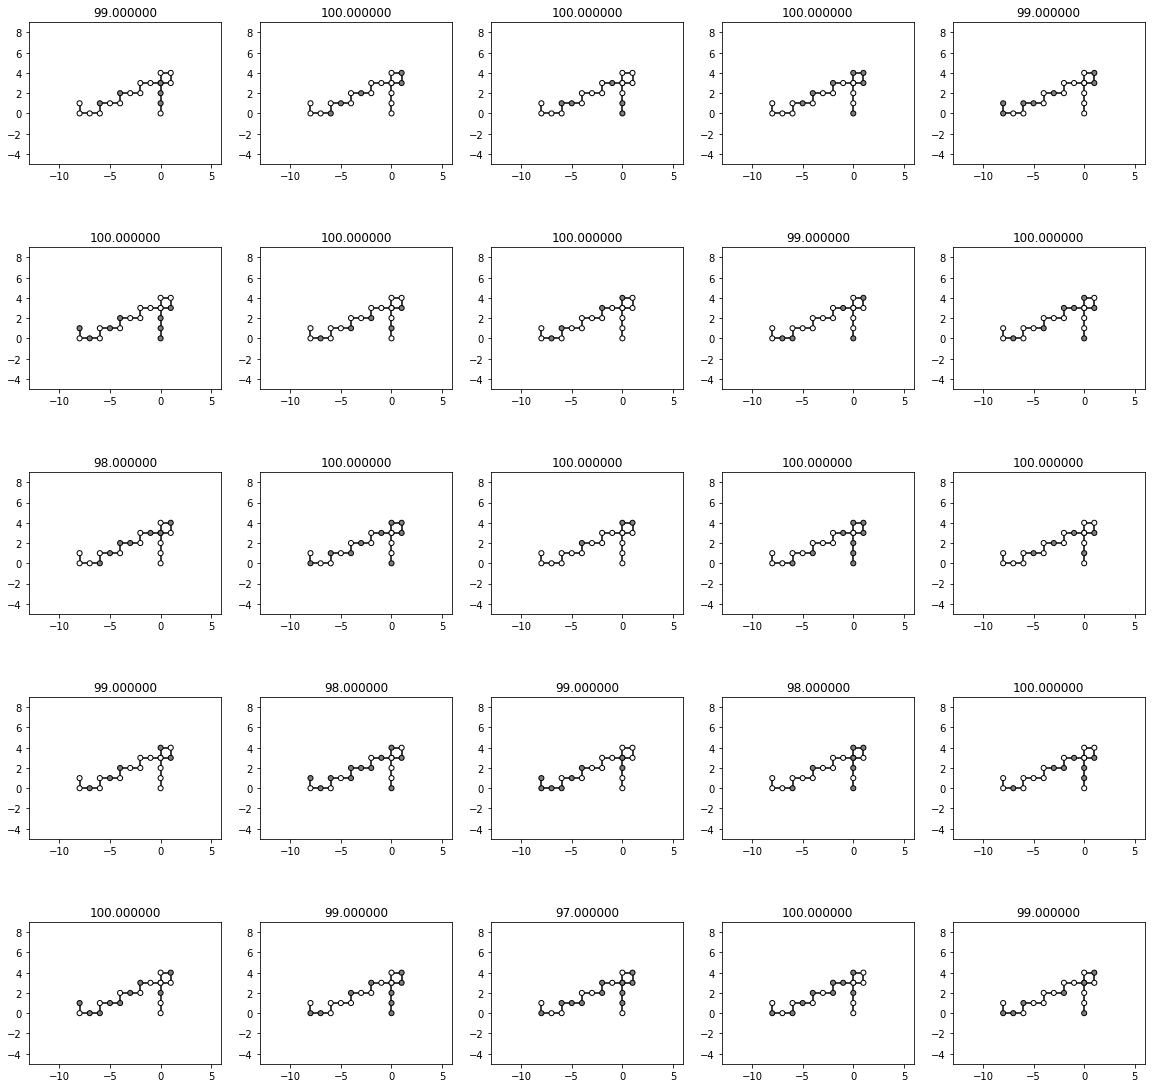

In [8]:
S = [HP.one_hot_seq_to_string(s) for s in sequences[25:50]]
C = [HP.sample_from_conf_one_hot(c) for c in conformations[25:50]]
hps = [HP(s,c) for s,c in zip(S,C)]
fig,ax = plt.subplots(5,5,figsize=(20,20))
for i in range(25):
    hps[i].show(ax[int(i/5),i%5])
    ax[int(i/5),i%5].set_title("%f" % hps[i].energy())

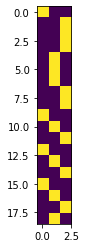

In [9]:
plt.imshow(conformations[0].cpu().detach().numpy())